# setup

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
from osgeo import gdal
from osgeo import ogr
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import os
from glob import glob


Nesse trabalho usarei dados de estações coletadas para meu projeto de IC. Coletamos dados mensais de todas estações pluviometricas da ANA disponiveis para o periodo 1981-2010. Chegamos em 478 estações.

In [4]:
ibge = gpd.read_file(r'data\IBGE\BiomasBrasil.shp')
shp_cerrado = ibge[ibge.biomas == 'CERRADO']
gdf = gpd.read_file('data\stations.geojson').to_crs(ibge.crs)
df_cerrado = pd.read_pickle(r'data\df_cerrado_bet.pkl').sort_values(['Code', 'Date']).reset_index(drop=True)
gdf_filtered = gdf[gdf.Code.isin(df_cerrado.Code.unique())].sort_values('Code').reset_index(drop=True)

In [5]:
#todas as estações no cerrado
gdf_filtered

,Code,Name,Latitude,Longitude,Altitude,geometry
0,343001,IGUARÁ,-3.5536,-43.8736,158.0,POINT (-43.87360 -3.55360)
1,343003,NINA RODRIGUES,-3.4594,-43.8989,112.0,POINT (-43.89890 -3.45940)
2,344004,CANTANHEDE,-3.6325,-44.3764,31.0,POINT (-44.37640 -3.63250)
3,344007,PERITORÓ II,-3.7097,-44.2933,145.0,POINT (-44.29330 -3.70970)
4,344008,PEDRAS,-3.9436,-44.0175,182.0,POINT (-44.01750 -3.94360)
...,...,...,...,...,...,...
473,2449044,SENGES,-24.1000,-49.4667,650.0,POINT (-49.46670 -24.10000)
474,2450002,TIBAJI,-24.5108,-50.4000,720.0,POINT (-50.40000 -24.51080)
475,2450026,COLÔNIA IAPÓ,-24.6331,-50.1331,1050.0,POINT (-50.13310 -24.63310)
476,2450031,GUARICANGA - PIRAI DO SUL,-24.3667,-50.1000,962.0,POINT (-50.10000 -24.36670)


<AxesSubplot: >

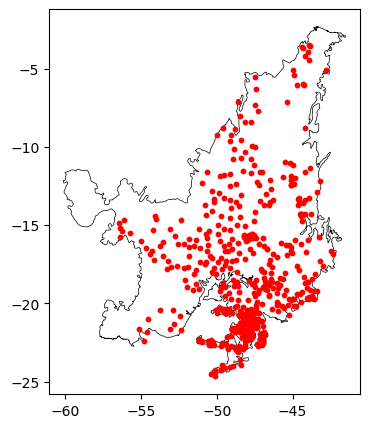

In [26]:
#plot todas estações e bioma
fig, ax = plt.subplots(figsize=(5,5))
shp_cerrado.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
gdf_filtered.plot(ax=ax, color='red', markersize=10, label='Estações')

In [6]:
#mostar nosso dataframe
df_cerrado

,Code,Date,Total
0,343001,1981-01-01,130.9
1,343001,1981-02-01,105.0
2,343001,1981-03-01,264.2
3,343001,1981-04-01,155.0
4,343001,1981-05-01,95.4
...,...,...,...
172075,2450036,2010-08-01,49.8
172076,2450036,2010-09-01,50.5
172077,2450036,2010-10-01,141.3
172078,2450036,2010-11-01,84.6


Vou calcular a climatologia da chuva anual para o periodo 1981-2010.

In [7]:
#calcular a chuva anual para cada ano de cada estação.
df_anual = df_cerrado.groupby(['Code', df_cerrado.Date.dt.year]).sum().reset_index()
df_anual

C:\Users\luisg\AppData\Local\Temp\ipykernel_1580\3603348216.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_anual = df_cerrado.groupby(['Code', df_cerrado.Date.dt.year]).sum().reset_index()


,Code,Date,Total
0,343001,1981,923.904378
1,343001,1982,1683.156402
2,343001,1983,839.732734
3,343001,1984,2178.421370
4,343001,1985,2646.735000
...,...,...,...
14335,2450036,2006,1017.500000
14336,2450036,2007,1763.942818
14337,2450036,2008,1369.400000
14338,2450036,2009,1751.051333


Text(0.5, 1.0, 'Chuva anual média no Cerrado')

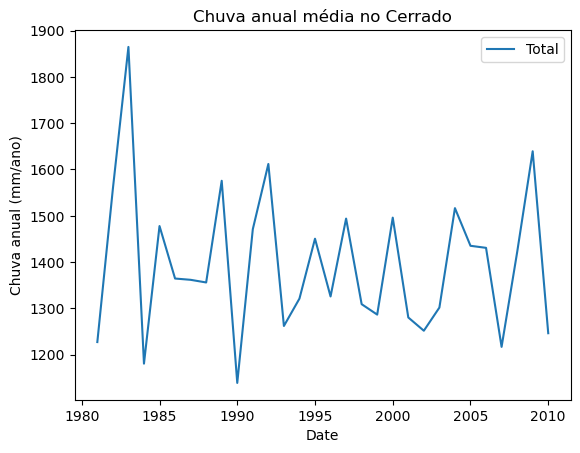

In [10]:
df_anual.groupby('Date').mean().plot(y='Total')
plt.ylabel('Chuva anual (mm/ano)')
plt.title('Chuva anual média no Cerrado')

In [29]:
#fazer a média de cada estação
df_clim = df_anual.drop(columns=['Date']).groupby('Code').mean().reset_index()
df_clim

,Code,Total
0,343001,1648.372060
1,343003,1639.300498
2,344004,1843.834369
3,344007,1710.997369
4,344008,1700.854109
...,...,...
473,2449044,1454.745074
474,2450002,1599.085986
475,2450026,1604.488315
476,2450031,1636.017345


In [30]:
#unir com o geodataframe
gdf_clim = gdf_filtered.merge(df_clim, on='Code')
gdf_clim

,Code,Name,Latitude,Longitude,Altitude,geometry,Total
0,343001,IGUARÁ,-3.5536,-43.8736,158.0,POINT (-43.87360 -3.55360),1648.372060
1,343003,NINA RODRIGUES,-3.4594,-43.8989,112.0,POINT (-43.89890 -3.45940),1639.300498
2,344004,CANTANHEDE,-3.6325,-44.3764,31.0,POINT (-44.37640 -3.63250),1843.834369
3,344007,PERITORÓ II,-3.7097,-44.2933,145.0,POINT (-44.29330 -3.70970),1710.997369
4,344008,PEDRAS,-3.9436,-44.0175,182.0,POINT (-44.01750 -3.94360),1700.854109
...,...,...,...,...,...,...,...
473,2449044,SENGES,-24.1000,-49.4667,650.0,POINT (-49.46670 -24.10000),1454.745074
474,2450002,TIBAJI,-24.5108,-50.4000,720.0,POINT (-50.40000 -24.51080),1599.085986
475,2450026,COLÔNIA IAPÓ,-24.6331,-50.1331,1050.0,POINT (-50.13310 -24.63310),1604.488315
476,2450031,GUARICANGA - PIRAI DO SUL,-24.3667,-50.1000,962.0,POINT (-50.10000 -24.36670),1636.017345


Text(0.5, 1.0, 'Precipitação anual média (1980-2010) no Cerrado')

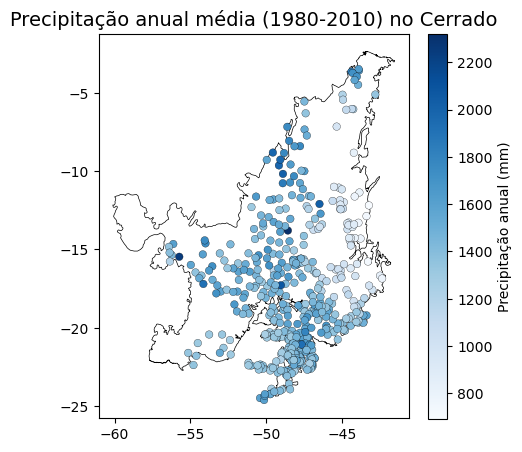

In [31]:
fig, ax = plt.subplots(figsize=(5,5))
shp_cerrado.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
gdf_clim.plot(ax=ax, column='Total', markersize=30, legend=True, label='Estações', cmap='Blues', edgecolor='black', linewidth=0.2, legend_kwds={'label': "Precipitação anual (mm)"})
#titulo
ax.set_title('Precipitação anual média (1980-2010) no Cerrado', fontsize=14)

In [32]:
gdf_clim.to_file('data\gdf_clim.shp')

# interpolação

agora vamos fazer a interpolação desses resultados.

In [33]:
#get max and min values of lat lot in gdf_clim
minx, miny, maxx, maxy = gdf_clim.total_bounds
res = 2000

In [36]:
# usaremos o metodo de interpolacao Inverso da potência das distâncias
idw = gdal.Grid("data\invdist.tif", 'data\gdf_clim.shp', zfield = "Total",
                algorithm = "invdist",outputBounds = [minx-20, miny-20, maxx+20, maxy+20], width = res, height = res)

#clip it for cerrado
ds = rioxarray.open_rasterio("data\invdist.tif")
ds_cerrado = ds.rio.clip(shp_cerrado.geometry.apply(mapping), shp_cerrado.crs)


agora visualiremos lado a lado a interpolação e os dados originais das estações

In [39]:
#plotar os 2 plots iguais, e usar uma cbar com levels 10?

my_proj = ccrs.PlateCarree()
vmin= 500
vmax= 2000
levels= 11
cmap = mpl.cm.Blues
proj = ccrs.Mercator()
bounds = np.linspace(vmin,vmax,levels)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# fake up the array of the scalar mappable. Urgh...
sm._A = []



C:\Users\luisg\AppData\Local\Temp\ipykernel_6900\801818573.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


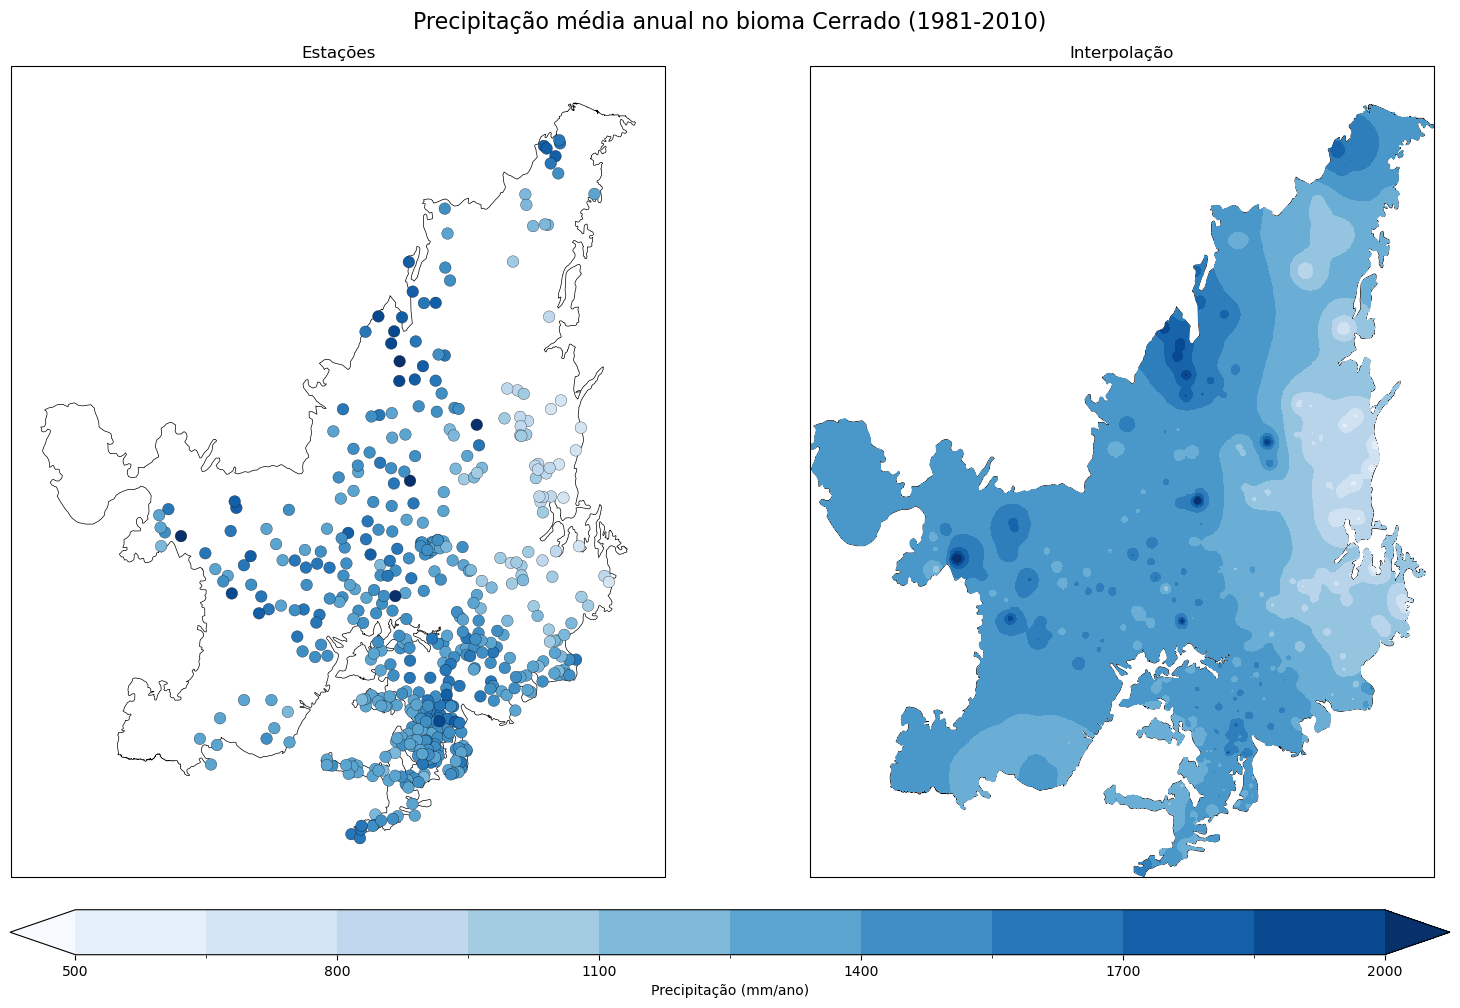

In [40]:

fig, ax = plt.subplots(1,2, figsize=(16,9),  subplot_kw={"projection": my_proj})
cax = fig.add_axes([0.05, -0.07, 0.9, 0.05])
fig.colorbar(sm, cax=cax, orientation='horizontal', label='Precipitação (mm/ano)')

shp_cerrado.plot(ax=ax[0], color='none', edgecolor='black', linewidth=0.5)
gdf_clim.plot(ax=ax[0], column='Total', cmap=cmap,   scheme="User_Defined", 
                classification_kwds=dict(bins=bounds), linewidth=0.2,
                  edgecolor='black',markersize=70)

shp_cerrado.plot(ax=ax[1], color='none', edgecolor='black', linewidth=0.5)
#add colorbar horizontal that covers all the figure
ds_cerrado.plot(ax=ax[1], cmap=cmap, vmin=vmin, vmax=vmax, levels=11, add_colorbar=False)
ax[1].set_title('Interpolação')
ax[0].set_title('Estações')
#titulo
fig.suptitle('Precipitação média anual no bioma Cerrado (1981-2010)', fontsize=16)
plt.tight_layout()

# Xavier

In [41]:
# Specify the path to the folder containing the NetCDF files
folder_path = r"D:\GU\IC\Scripts\Data\Datasets\raw\xavier"
# Open and concatenate all the NetCDF files
ds = xr.open_mfdataset(os.path.join(folder_path, '*.nc'), combine='by_coords')
# Transform daily data to monthly
ds_monthly = ds.resample(time='1M').mean()
#from mm/day to mm/month
ds_monthly['pr'] = ds_monthly['pr'] * 30
#select 1981-2010 period and take anual mean
ds_clim = ds_monthly.sel(time=slice('1981-01-01', '2010-12-31')).groupby('time.year').sum(dim='time').mean(dim='year')
ds_clim.rio.write_crs(shp_cerrado.crs, inplace=True)
xavier_cerrado = ds_clim.rio.clip(shp_cerrado.geometry.apply(mapping), shp_cerrado.crs)
xavier_cerrado = xavier_cerrado.load()


C:\Users\luisg\AppData\Local\Temp\ipykernel_6900\2994874841.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


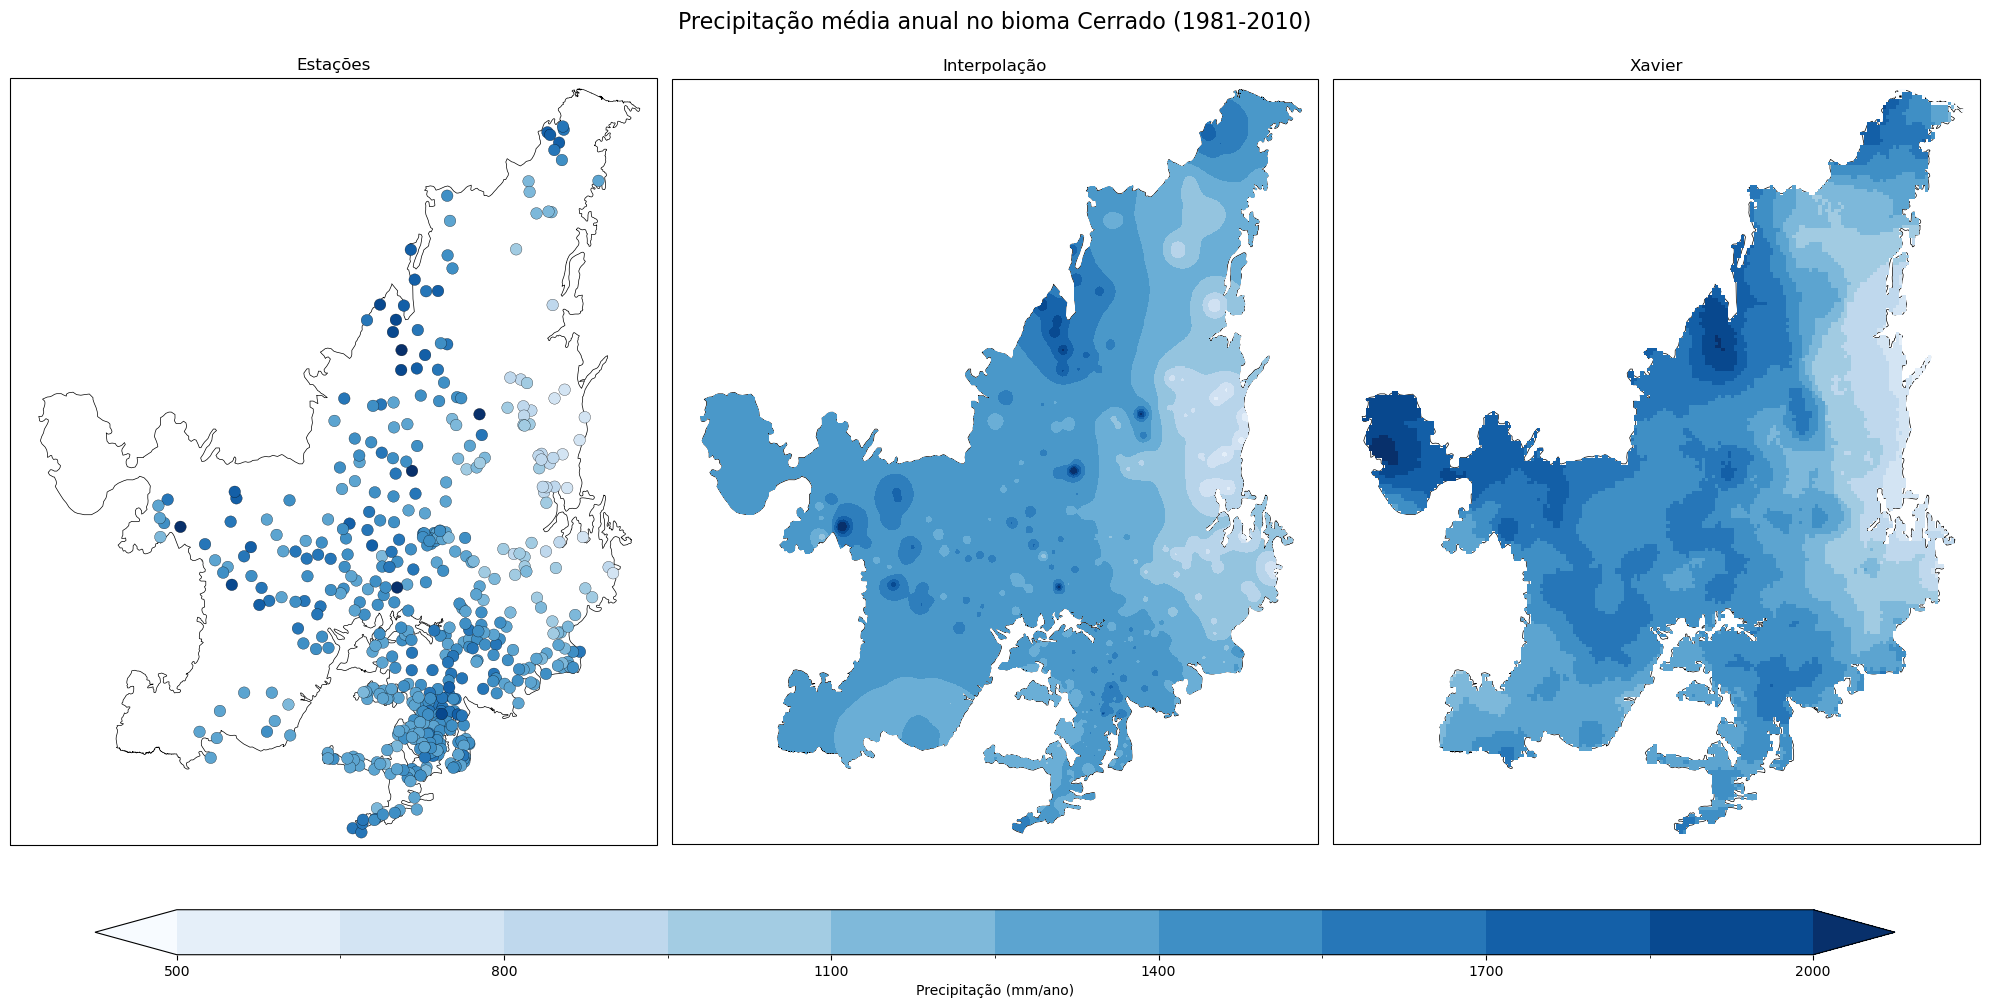

In [48]:

fig, ax = plt.subplots(1,3, figsize=(20,9),  subplot_kw={"projection": my_proj})
cax = fig.add_axes([0.05, -0.07, 0.9, 0.05])
fig.colorbar(sm, cax=cax, orientation='horizontal', label='Precipitação (mm/ano)')

shp_cerrado.plot(ax=ax[0], color='none', edgecolor='black', linewidth=0.5)
gdf_clim.plot(ax=ax[0], column='Total', cmap=cmap,   scheme="User_Defined", 
                classification_kwds=dict(bins=bounds), linewidth=0.2,
                  edgecolor='black',markersize=70)

shp_cerrado.plot(ax=ax[1], color='none', edgecolor='black', linewidth=0.5)
ds_cerrado.plot(ax=ax[1], cmap=cmap, vmin=vmin, vmax=vmax, levels=11, add_colorbar=False)

shp_cerrado.plot(ax=ax[2], color='none', edgecolor='black', linewidth=0.5)
xavier_cerrado.pr.plot(ax=ax[2], cmap=cmap, vmin=vmin, vmax=vmax, levels=11, add_colorbar=False)

ax[1].set_title('Interpolação')
ax[0].set_title('Estações')
ax[2].set_title('Xavier')

#set same extend
ax[0].set_extent([-61, -41, -25, -2])
ax[1].set_extent([-61, -41, -25, -2])
ax[2].set_extent([-61, -41, -25, -2])

#titulo
fig.suptitle('Precipitação média anual no bioma Cerrado (1981-2010)', fontsize=16)
plt.tight_layout()